# Voltage clamp analysis - teaching/troubleshooting notebook


This notebook is a deconstructed version of v5 of the V-clamp and I-clamp analysis scripts. Sections:

1. File management and organization
2. ABF files and voltage clamp / current clamp data 
3. Extracting measurements from ephys data 

Down the line once 1-3 are covered thoroughly:
4. Plotting summary figures of whole dataset 
5. Statistics of input-output curve 

## 1. File management and organization

In [2]:
# A bunch of different libraries for managing directories, will be explained along the way
import pyabf #ABF library for python, main thing we'll use
import os #for moving around directories
import os.path #for setting paths
import csv #for opening-editing comma-separater value files
from tkinter import Tk
from tkinter import filedialog
from tkinter import Tk

from tkinter.filedialog import askdirectory #for opening and closing GUIS for selecting files
import pandas as pnd #tables for python! Pandas is your friend.
import matplotlib.pyplot as plt #plotting for python! Matplotlib is your BEST friend.

Our goal with these analysis scripts is to  summarizes some important aspect of our dataset, be it a specific measurement or a summary of each datapoint's characteristics. To accomplish this we need a script that iterates through every sample (we will consider these _cells_ because there is a corresponding folder with many ABF files per cell, and a single recorded cell can be considered a sample of n = 1). In each iteration, the script should call certain functions to read the data and extract some feature. In our case, this feature is the amplitude of an Excitatory Post-Synaptic Current (EPSC). Once we explore the ABF files we will figure out how we read and measure the data itself. For now we will focus on a "skeleton" script that only searches for every sample in the dataset, and will later plug in the functions we need to extract the measurements.

In [57]:
def get_mV_step_interval(abf):
    """Parses through raw text to obtain mV step interval in membrane test.
    Assumes that there is only a single voltage step in voltage-clamp configuration experiments
    
    arguments:
    abf = loaded abf file with pyabf.ABF(filename)
    """
    raw_str = str(abf.sweepEpochs)
    parsed_str = raw_str.split(', ') #separate by commas
    parsed_total = (len(parsed_str)) 
    for i in range(parsed_total):
        if '0.00' not in parsed_str[i]: #if there's a non-zero value of the command waveform at this epoch
            # also stolen: this extracts string inside []
            values = parsed_str[i][parsed_str[i].find("[")+1:parsed_str[i].find("]")]
    step_points = (values.split(':'))
    step_start, step_end = int(step_points[0]), int(step_points[1])
    return step_start, step_end

def get_xlxs_data(mouse,contents): 
    """For now: gets number of cells per experiment, intensities of stimuli, and list of validated ABF files
    arguments:
    mouse = str, name of mouse 
    contents = output from os.listdir('.'), directory of folder with data from one cell
    """
    for file in contents:
        if mouse in file and '~$' not in file: #excel file has the name of the mouse, and ~$ is in case there's a temp
            exp_notes = pnd.read_excel(file)
            stim_int = exp_notes['Stim Intensity (uA)'].tolist()
            stim_int.pop(0)
            cellnum = exp_notes['cellnum']
            cellnum = int(cellnum[0]) 
            valid_ABFs = exp_notes['File'].tolist()
            valid_ABFs.pop(0)
            for x in range(len(valid_ABFs)):
                valid_ABFs[x] = valid_ABFs[x].strip('\t\n') #cleanup
    return stim_int, cellnum, valid_ABFs

In [38]:
print(os.getcwd())

/Users/adrianalejandro/Desktop/Ephys_pipeline/Input-Output/VClamp_ABF_tutorial


When you run the cell below, first pick the excel file in your sample dataset. Afterwards, choose the folder _named_ `sample_dataset`.

In [39]:
os.chdir('/Users/adrianalejandro/Desktop/Ephys_pipeline/Input-Output/VClamp_ABF_tutorial') #SWITCH TO DIRECTORY THIS NOTEBOOK IS IN

#Step 0 - Choose excel file with genotypes, this tells you which samples are which genotype
global_df = pnd.DataFrame()
gentp_filename = filedialog.askopenfilename()
genotypes = pnd.read_excel(gentp_filename)
datapoint = 0 # This will increase by 1 with every iteration of making a dataframe for a cell, aka analyzing that cell

#Step 1 - Select Folder with all data needed for input-output curve 
path = askdirectory() # shows dialog box and return the path 
os.chdir(path) #change working directory to dataset

if os.path.exists('.DS_Store') == True: #external drive issue with Adrian's computer, shouldn't hurt anything
    os.remove('.DS_Store')          
gen_dir = os.getcwd()
mouse_folders = os.listdir('.')

#Step 2 - Go to each folder in dataset that corresponds to one mouse
for mousename in mouse_folders:  
    #Get genotype name of each mouse with genotype table!
    genotype = genotypes.loc[genotypes['mouse'] == mousename, 'genotype_short'].item() #parses through table using pandas
    mouse_dir = gen_dir + '/' + mousename # get directory for one mouse, this stitches together chunks of strings
    os.chdir(mouse_dir)  #change directory to that mouse
    if os.path.exists('.DS_Store') == True: # external drive again pls ignore :)
        os.remove('.DS_Store')    
    mouse_wd = os.getcwd() 
    cell_folders = os.listdir(mouse_wd) # list the cells (subfolders) of that mouse
#Step 3 -  Go to each subfolder that corresponds to each cell of one mouse    
    for cell in cell_folders:
        if cell == '.DS_Store': # external drive problem again
            os.remove('.DS_Store')    
        elif 'cell' in cell and 'processed' not in cell and 'IClamp' not in cell: #conditions that need to be met for the name of that cell
            processed_file = cell + '_processed' #create folder to dump the reporter figure for that cell, more on that later!
            processed_dir = mouse_wd + '/' + processed_file
            if not os.path.exists(processed_dir): #if there isn't a folder for the processed file, make one!
                os.mkdir(processed_dir)
            cell_dir = mouse_dir + '/' + cell
            os.chdir(cell_dir)# change directory to one cell of one mouse
            cell_wd = os.getcwd()
            if os.path.exists('.DS_Store') == True: # external drive problem again
                os.remove('.DS_Store')       
# Step 3.1 -Create metadata in case its not there already - the csv files we might need           
            contents = os.listdir(cell_wd) # list all contents of this cell
            print(contents)
            stim_int, cellnum, stim_ABFs = get_xlxs_data(mousename,contents)
# KEY STEP 3.3 - Generate dataframes and save onto processed folder, one per each cell (could be 2 per cell folder)
            cell_channels = [*range(cellnum)]  
            for ch in cell_channels: 
                datapoint = datapoint + 1 # will later be used to know how many datapoints in input-output curve
                print('Sample ',datapoint,' of genotype ',genotype) #to see where we are in the dataset in each iteration
                
                #IGNORE RED TEXT IT IS FOR LATER
                '''
                ch_ind = ch*2 #comment this kind of key variable!
                cell_ID = ch + 1
                print(valid_ABFs)
                summary,all_peak_times,cell_fig = data_summary_percell_v3(cell,ch_ind,valid_ABFs,valid_CSVs,
                                                                           stim_int,genotype,datapoint)
                global_df = global_df.append(summary, ignore_index=True)
                
                summ_path = processed_dir + '/' + cell + '_' + str(cell_ID) + '_summary.csv'      
                plot_path = processed_dir + '/'  + cell + '_' + str(cell_ID) + '_plot'      
                summary.to_csv(summ_path, index = True)
                plt.savefig(plot_path)
                '''

['19d14008.abf', '19d14003.abf', '19d14002.abf', '19d14000.abf', '19d14001.abf', '19d14005.abf', '19d14004.abf', '19d14006.abf', '19d14007.abf', '~$131219_SCH-028952slice2cell2.xlsx', '131219_SCH-028952slice2cell2.xlsx']
Sample  1  of genotype  WT


/Users/adrianalejandro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: `item` has been deprecated and will be removed in a future version


## 2. ABF files and Voltage clamp data (Matplotlib!)

To get a sense of how to measure the data properly, we need a method to visualize it. Python has a comprehensive library named `Matplotlib` that is equipped to plot virtually anything that is a clear enough sequence of numbers. Plotting is an incredibly useful tool for understanding your data, from the raw traces to whatever transofrmations you put it through in your analysis. Let's break list a few key functions you'll be using and adapting a lot by choosing a single cell from the data in a new folder named `sample_dataset`.

The first thing we need is a list of the files present for one cell. Luckily, we have an excel file that describes what each file is about! In this case, the excel files are just a table where each abf file has a corresponding stimulus intensity in microamps given during that recording. Using pandas we can make a table with each file and its stimulus, which is an essential part of the input-output curve.

In [41]:
#BEFORE U DO ANYTHING GET THE PATH TO YOUR CELL FOLDER
sample_path = '/Users/adrianalejandro/Desktop/Ephys_pipeline/Input-Output/VClamp_ABF_tutorial/sample_dataset/131219_SCH-028952/028952slice2cell2' # EDIT TO YOUR DIRECTORY
os.chdir(sample_path)
print(os.listdir())
excel = '131219_SCH-028952slice2cell2.xlsx'
stimtable = pnd.read_excel(excel)
stimtable = stimtable[['File','Stim Intensity (uA)','notes']]
print(stimtable)


['19d14008.abf', '19d14003.abf', '19d14002.abf', '19d14000.abf', '19d14001.abf', '19d14005.abf', '19d14004.abf', '19d14006.abf', '19d14007.abf', '~$131219_SCH-028952slice2cell2.xlsx', '131219_SCH-028952slice2cell2.xlsx']
           File Stim Intensity (uA) notes
0  19d14000.abf        Baseline+bic  35uM
1  19d14001.abf                0.01   NaN
2  19d14002.abf               0.025   NaN
3  19d14003.abf                0.05   NaN
4  19d14004.abf               0.075   NaN
5  19d14005.abf                 0.1   NaN
6  19d14006.abf                0.25   NaN
7  19d14007.abf                 0.5   NaN
8  19d14008.abf                0.75   NaN


The first file isn't really a stimulus intensity so we can ignore it for now. The pipeline actually uses this to get membrane resistance and series resistance for each cell, which serves as a way to assess the overall health of the cell. We can have a look at that later but it's not essential for the dataset for now. 

In [42]:
stimtable = stimtable.drop(stimtable.index[0]) #'drop' removes rows of dataframe manually. Later we will learn how
                                               # to do this programatically
print(stimtable)

           File Stim Intensity (uA) notes
1  19d14001.abf                0.01   NaN
2  19d14002.abf               0.025   NaN
3  19d14003.abf                0.05   NaN
4  19d14004.abf               0.075   NaN
5  19d14005.abf                 0.1   NaN
6  19d14006.abf                0.25   NaN
7  19d14007.abf                 0.5   NaN
8  19d14008.abf                0.75   NaN


Let's pick a single file for now to play around with plotting the data. Since the bigger the stimulus intensity the bigger the response, let's go with  0.1 microamperes. 

In [43]:
file = '19d14005.abf' #filename as string, a type of variable we'll encounter often
abf = pyabf.ABF(file)

print(abf.sweepList) #a class variable embedded in the abf file tells you how many 'sweeps' there are

[0, 1, 2, 3, 4, 5, 6]


There are 7 sweeps in this trace (__central dogma of Python is that everything initializes at zero__), so we need to think of a way we could plot each one of these onto one figure so we can see individual differences. They should all look the same since they're all a post-synaptic response to the same presynaptic stimulus current. Let's look at just one.

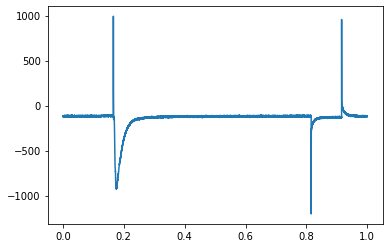

In [44]:
abf.setSweep(0,channel=0) #set sweep# and channel, 0 = current, 1 = holding voltage, should be static
plt.plot(abf.sweepX,abf.sweepY) #X is time in seconds, Y is signal, these traces are both in the abf file

The first part of the trace is the stimulus, the second one is a brief membrane test, and we can confirm that by plotting both channels. We could use this in the future to test if there was anything weird going on in the cell during this trace because it would reflect poorly on the membrane and series resistances. For example, a loose seal or an unhealthy cell would reflect an unstable or unusually low resistance.

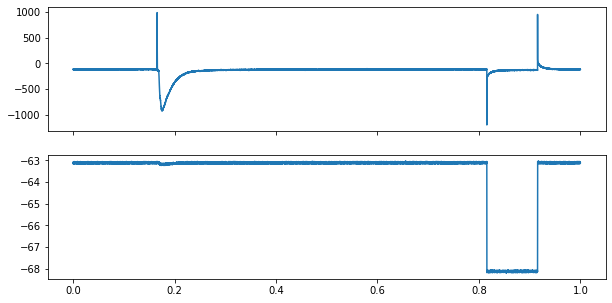

In [45]:
f,axs = plt.subplots(2,1,figsize=(10,5),sharey=False, sharex=True) #f is figure, axs are axis handles
abf.setSweep(0,channel=0) #set channel to current
axs[0].plot(abf.sweepX,abf.sweepY) #first axes
abf.setSweep(0,channel=1) #set channel to voltage
axs[1].plot(abf.sweepX,abf.sweepY) #second axes

Let's employ a method to plot all the traces together, which honestly doesn't look that different because they're very similar to each other. However, to get a much clearer picture of individual differences of each trace and the shape of the traces, we can modify the y-axis limits to only focus on the range of the EPSC and not the capacitative currents.

(-1200, 0)

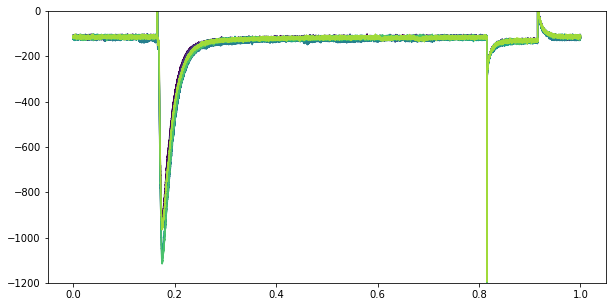

In [46]:
cm = plt.get_cmap("viridis") #Make colormap to distinguish sweeps
colors = [cm(x/abf.sweepCount) for x in abf.sweepList]
f = plt.figure(figsize=(10,5))
for i in abf.sweepList:
    abf.setSweep(i,channel=0)
    plt.plot(abf.sweepX,abf.sweepY,color=colors[i])
plt.ylim(-1200,0) #plot only from -1200 o 0 picoamperes

Two things we can tell right away: the trace lasts exactly one second and we only need the first half to get a decent glimpse of what the EPSC looks like. Below is the same method as above with some extra tricks to slice the trace in half using indices:

In [47]:
print(abf.dataRate) #datarate is like 'frames per second', so this number equals the amount of 'frames' per trace

20000


(-1200, 0)

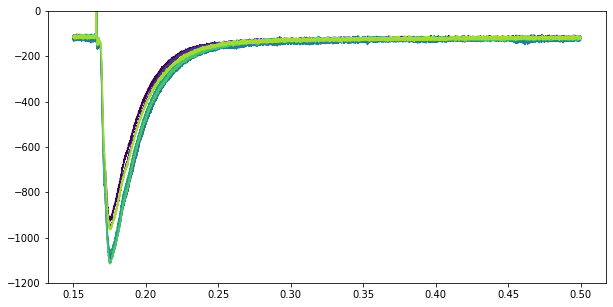

In [48]:
cm = plt.get_cmap("viridis") #Make colormap to distinguish sweeps
colors = [cm(x/abf.sweepCount) for x in abf.sweepList]
f = plt.figure(figsize=(10,5)) #make figure handle just to modify figure size, make veeery looong to see trace better
for i in abf.sweepList:
    abf.setSweep(i,channel=0)
    plt.plot(abf.sweepX[3000:10000],abf.sweepY[3000:10000],color=colors[i]) #[3000:10000] stands for
                                                                            #'between these indices'
plt.ylim(-1200,0)

The traces are a little bit different from each other but they're more or less the same response. The way that we plotted this one, we implicitly "sliced" the trace so that only a section of interest is displayed. In reality we want to only take measurements from a specific window in our trace because there are often artifacts all over the place that we could measure by mistake. For this data, the artifacts are actually a capacitative current, which can obscure any functions that we employ on the data to find a certain feature. An EPSC has several components, such as a rise time, decay time, and peak amplitude. For now we will search the peak amplitude because it's a rough but easily measurable and reliable measure of how strong a synaptic response is to a presynaptic stimulus. Remember, we're measuring this to get an input-output curve! 

We first slice the data more precisely to capture the start of the trace. Then we use a numpy (numbers for python haha) function called `min` to find the minimum of the data, which is the lowest current amplitude, aka the peak. 

Text(0, 0.5, 'current (pA)')

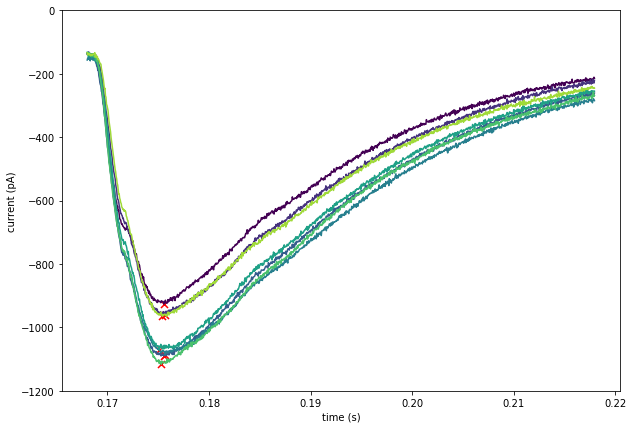

In [49]:
import numpy as np
EPSC_start = int(0.168*abf.dataRate) #index of timepoint where the stimulus is given, at 0.168 seconds!!
EPSC_end = EPSC_start + int(0.050*abf.dataRate) #timepoint 50 milliseconds
f = plt.figure(figsize=(10,7)) #make figure handle just to modify figure size, make veeery looong to see trace better
for i in abf.sweepList:
    abf.setSweep(i,channel=0)
    plt.plot(abf.sweepX[EPSC_start:EPSC_end],abf.sweepY[EPSC_start:EPSC_end],color=colors[i]) #[3000:10000] stands for
    peak = np.min(abf.sweepY[EPSC_start:EPSC_end]) #'between these indices' #find biggest negative current
    peak_index = np.argmin(abf.sweepY[EPSC_start:EPSC_end]) + EPSC_start #find the index in the trace of that current
    #plt. scatter is just for scatter plots... but who says you can't plot a single point?
    plt.scatter(abf.sweepX[peak_index],peak,marker='x',s=50,color='red')
plt.ylim(-1200,0)
plt.xlabel('time (s)')
plt.ylabel('current (pA)')

What is displayed above is essentially the part of the trace we will always measure. In the next section we will address how to simultaneously take these measurements we've plotted and saved them to a `DataFrame`, or a pandas table, as I like to think of it. 

__Q1: Before exploring the next section, a bit of thinking on how this method works. How are we able to plot every single current trace of this abf file? What part of the code enables this and why?__

__Q2: On the code above we use both `min` and `argmin` to find and then plot the peak amplitude. Why do we need both?__

## 3. Extracting measurements from ephys data (Pandas!)

As we've seen so far, most if not all of the code we employ to sift through files and plot traces contains some instance of a loop,specifically, a `for` loop which is honestly the only kind of loop I ever use (will update this if I ever use a `while`, which can be super useful as well). A `for` loop simply iterates over a given variable, be it a list or a table, and runs whatever code you specify in it every time. The indices we use for this on individual abf files is `abf.sweepList`, which is a list of the number for every sweep (every voltage and current trace). Because of the nature of this experiment, we need to do this over a bunch of abf files that all form the data of one cell. Essentially, we need to run a for loop *inside* another for loop, and you might eventually notice that this is true at every step of the pipeline.

Now the most useful part of the pipeline: table-making. We will use the same method in section two but with some extra code that will create a dataframe with the different measurements we take from the traces, as well as with some variables that will later help us distinguish to which cells this piece of the whole dataset they belong to.

In [50]:
stimtable #recall this from section two

,File,Stim Intensity (uA),notes
1,19d14001.abf,0.01,NaN
2,19d14002.abf,0.025,NaN
3,19d14003.abf,0.05,NaN
4,19d14004.abf,0.075,NaN
5,19d14005.abf,0.1,NaN
6,19d14006.abf,0.25,NaN
7,19d14007.abf,0.5,NaN
8,19d14008.abf,0.75,NaN


In [54]:
EPSC_start = int(0.168*abf.dataRate) #index of timepoint where the stimulus is given, at 0.168 seconds!!
EPSC_end = EPSC_start + int(0.050*abf.dataRate) #timepoint 50 milliseconds
stim_ints = stimtable['Stim Intensity (uA)'].tolist() # converts a whole column of a table into a list
abf_filenames = stimtable['File'].tolist() #get abf filenames as well
mean_peaks = [] #will pile the peaks we find onto this list

#for now we define these three, but we will later see how we can derive them from our dataset
stim_int = '0.1'
genotype = 'WT'
datapoint = 1 

peak_inds = [] #will pile the indices of the peaks we find too
for i, row in stimtable.iterrows(): #pandas-built functiont that iterates over rows in the table
    file = row.File
    abf = pyabf.ABF(file)
    sweep_peaks = []
    
    for i in abf.sweepList: #loop on the list of sweeps of each abf file
        abf.setSweep(i,channel=0)
        peak = np.min(abf.sweepY[EPSC_start:EPSC_end]) #'between these indices' #find biggest negative current
        sweep_peaks.append(peak) #append each peak of every sweep at a single intensity
        #loop-loop ends here
    #loop ends here

    mean_peak = np.mean(sweep_peaks) #get mean value of the 7 peaks of the 7 identical EPSCs with the same stimulus
                                     #(refer to section 2 for example)
    mean_peaks.append(mean_peak) #append this mean EPSC peak amplitude to list that contains one per each 
                                 #stimulus intensity
print(stim_ints,abf_filenames,mean_peaks)
        



[0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75] ['19d14001.abf', '19d14002.abf', '19d14003.abf', '19d14004.abf', '19d14005.abf', '19d14006.abf', '19d14007.abf', '19d14008.abf'] [-142.90945, -296.97964, -594.4824, -856.32324, -1030.7966, -1128.3656, -918.4047, -856.7592]


With all of these lists we're now able to make a dataframe. Using the `zip` we first combine the lists into a `tuple` type variable (each element in a tuple contains several values, which a list _can_ do but unlike lists, tuples cannot be changed unless you redefine the variable). We then turn this tuple variable into a list using `list`, where each element in said list contains a single value for stimulus intensity, filename, and EPSC peak.

In [55]:
datapoint_list = [datapoint for l in range(len(stim_ints))] #makes a list of the same value over and over as long as
                                                          #another list 
genotype_list = [genotype for l in range(len(stim_ints))]
data_tuple = list(zip(abf_filenames,stim_ints,mean_peaks,datapoint_list,genotype_list))
print(data_tuple)        

[('19d14001.abf', 0.01, -142.90945, 1, 'WT'), ('19d14002.abf', 0.025, -296.97964, 1, 'WT'), ('19d14003.abf', 0.05, -594.4824, 1, 'WT'), ('19d14004.abf', 0.075, -856.32324, 1, 'WT'), ('19d14005.abf', 0.1, -1030.7966, 1, 'WT'), ('19d14006.abf', 0.25, -1128.3656, 1, 'WT'), ('19d14007.abf', 0.5, -918.4047, 1, 'WT'), ('19d14008.abf', 0.75, -856.7592, 1, 'WT')]


The dataframe is created with the following. Note that we added this thing called `datapoint`. Down the line this will be super helpful in helping us distinguish values from one cell (sample of n=1!!!) from the next.

In [56]:
column_names = ["abf_filename","stimulus_intensity_uA","Peak_amplitude_pA","datapoint","genotype"] #MANUALLY SET!!! 
cell_df = pnd.DataFrame(data_tuple,index=None,columns=column_names)
cell_df

,abf_filename,stimulus_intensity_uA,Peak_amplitude_pA,datapoint,genotype
0,19d14001.abf,0.010,-142.909454,1,WT
1,19d14002.abf,0.025,-296.979645,1,WT
2,19d14003.abf,0.050,-594.482422,1,WT
3,19d14004.abf,0.075,-856.323242,1,WT
4,19d14005.abf,0.100,-1030.796631,1,WT
5,19d14006.abf,0.250,-1128.365601,1,WT
6,19d14007.abf,0.500,-918.404724,1,WT
7,19d14008.abf,0.750,-856.759216,1,WT


__Q3: Notice that we first created lists from the stimulus table, and then went full circle to create anothe dataframe based on this. This is what the real first pipeline made by Adrián did when this was written, and it might not be the most efficient method (I'll put myself on the spot and admit that it's probably the LEAST efficient method). If we already had a table that had the filename and stimulus intensities of a cell, what could we do differently?__ 

__Q4: Based on the format of `cell_df`, what could we do to combine this and table from all other cells in our dataset? After that, how could we sort between different groups of cells?__  